In [179]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [684]:
from src.train import train_model
from src.evaluate import plot_learning_curves, plot_psychometric_curve
from src.analysis import plot_pca_trajectories, decode_choice
from src.data_generator import TwoAFCGenerator
import torch
import os

In [809]:
lr = 1e-3
num_epochs =1000

In [810]:
trained_model, losses, _ = train_model(lr, num_epochs)

100%|██████████| 1000/1000 [00:17<00:00, 58.15it/s]

Time taken: 17.199634552001953
Step 1000/1000 — Loss: 0.2018, Acc: 90.0%


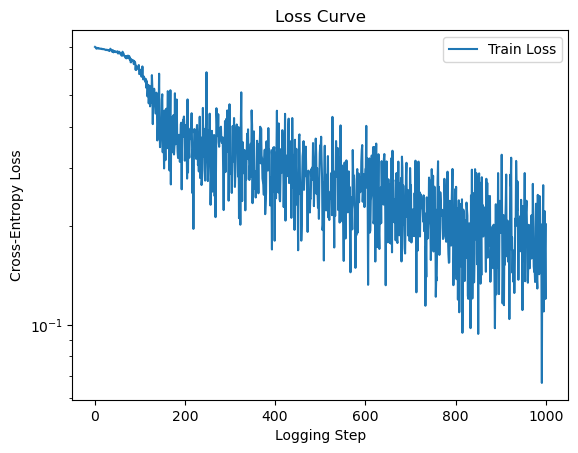

In [811]:
plot_learning_curves(losses)

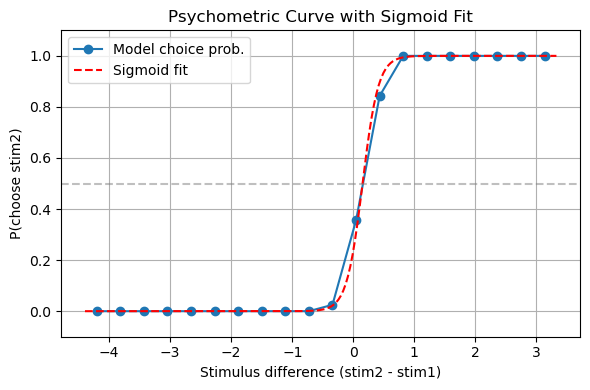

In [812]:
plot_psychometric_curve(trained_model)

In [813]:
current_dir = os.getcwd()

save_dir = os.path.abspath(os.path.join(current_dir, "..", "trained_models"))
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "trained_model.pt")
torch.save(trained_model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

Model saved to: C:\Users\shaur\Desktop\RNN_2AFC\trained_models\trained_model.pt


In [834]:
gen = TwoAFCGenerator(batch_size = 1000,
        fix_dur = 10,
        stim_dur = 20,
        delay_dur =5,
        decision_dur = 2,
        min_diff= 0,
        max_diff= 0.6,
        noise_level= 0.2)
inputs, targets = gen()

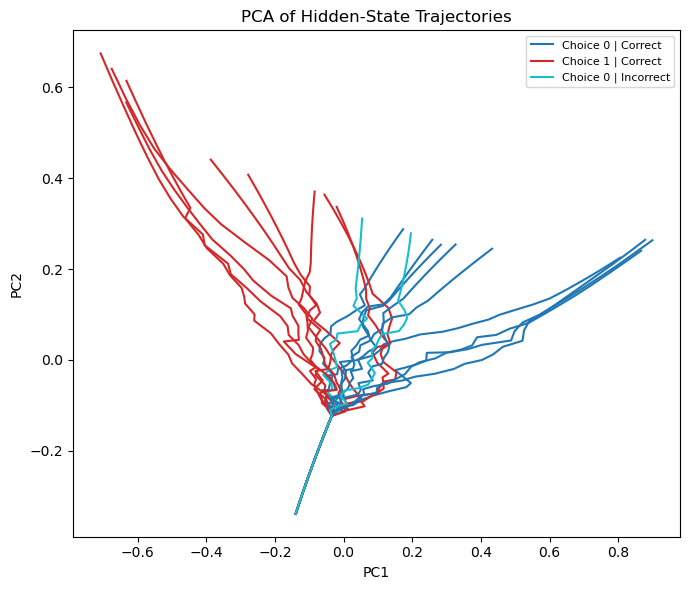

PCA(n_components=2)

In [833]:
plot_pca_trajectories(trained_model, inputs, targets, n_trials=20, n_components=2)

5-fold CV accuracy: 95.7% ± 0.2%


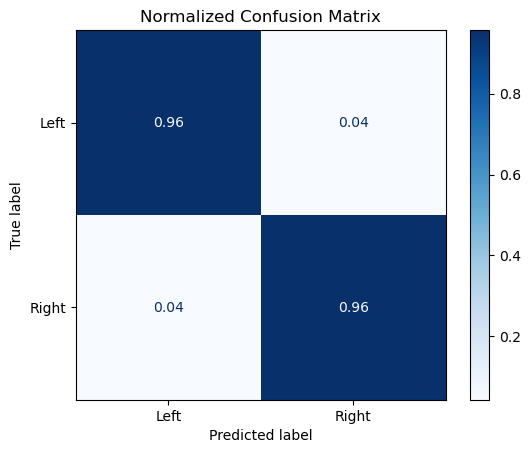

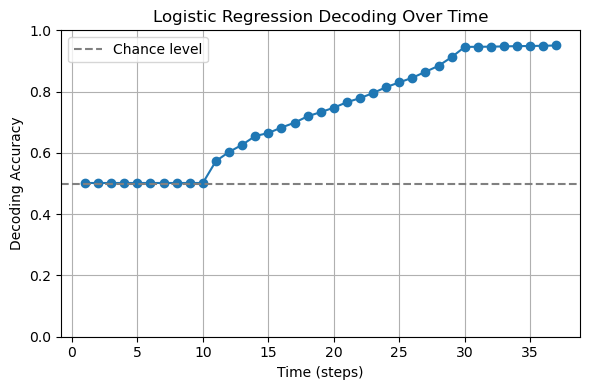

In [816]:
_ = decode_choice(trained_model, gen)

In [817]:
%cd ..\fixed_point_finder
print(os.getcwd())

C:\Users\shaur\Desktop\RNN_2AFC\fixed_point_finder
C:\Users\shaur\Desktop\RNN_2AFC\fixed_point_finder


In [818]:
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder

import numpy as np
from fixed_point_finder.plot_utils import plot_fps

In [819]:
inputs, targets = gen()
h_traj = []  
h = torch.zeros(inputs.size(1), trained_model.hidden_size)
for t in range(inputs.size(0)):
    # h = (1 - trained_model.alpha) * h + trained_model.alpha * \
    #     torch.relu(h @ trained_model.W_rec.t() + inputs[t] @ trained_model.W_in + trained_model.b_rec)
    # 
    u_t = h @ trained_model.W_rec.t() + inputs[t] @ trained_model.W_in + trained_model.b_rec
    h = (1 - trained_model.alpha) * h + trained_model.alpha * u_t
    h = torch.relu(h)
    
    h_traj.append(h.detach().cpu().numpy())

fpf = FixedPointFinder(rnn = trained_model)
h_traj = np.transpose(np.array(h_traj), (1, 0, 2))
initial_states = fpf.sample_states(h_traj, 1000)
x_const = np.random.randn(1, inputs.shape[-1])
# 
fixed_points, g = fpf.find_fixed_points(initial_states=initial_states,
                                        inputs=x_const)
print(f"Found {len(fixed_points)} unique fixed points")



Searching for fixed points from 1000 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		785 iters
		q = 1.86e+03 +/- 2.30e+01
		dq = 0.00e+00 +/- 0.00e+00
		learning rate = 1.53e-06
		avg iter time = 2.19e-03 sec
	Identified 723 unique fixed points.
		initial_states: 0 outliers detected (of 1000).
		fixed points: 723 outliers detected (of 723).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.

Found 0 unique fixed points
